Final summary:
Fixed LR  - Train Acc: 0.8650, Test Acc: 0.8600
Backtrack - Train Acc: 0.9800, Test Acc: 0.9800


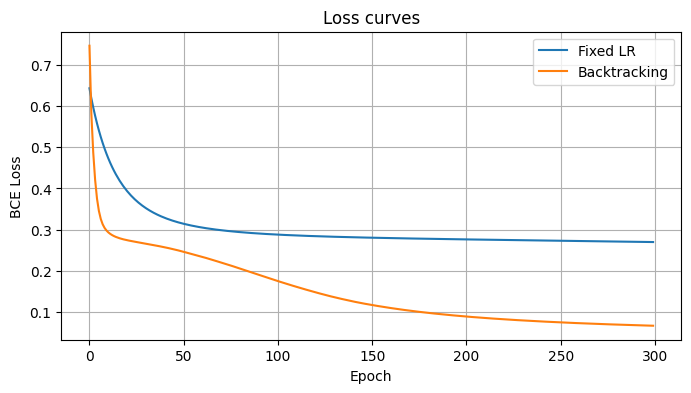

In [ ]:
# pytorch_backtracking_demo.py
# Simple PyTorch demo: Fixed LR SGD vs GD + Backtracking (Armijo)
# Requirements: torch, scikit-learn, matplotlib (optional)
# Run in Colab or local env.

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cpu")

# ---- Data ----
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

X_train_t = torch.from_numpy(X_train).to(device)
X_test_t = torch.from_numpy(X_test).to(device)
Y_train_t = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(1).to(device)
Y_test_t = torch.from_numpy(y_test.astype(np.float32)).unsqueeze(1).to(device)

# ---- Model ----
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=2, hidden=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # logits (will use BCEWithLogitsLoss)
        return x

def accuracy(model, X, Y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        preds = (torch.sigmoid(logits) > 0.5).float()
        return (preds == Y).float().mean().item()

# ---- Training: Fixed LR (SGD) ----
model_fixed = SimpleMLP().to(device)
opt_fixed = torch.optim.SGD(model_fixed.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()

epochs = 300
losses_fixed = []

for epoch in range(epochs):
    model_fixed.train()
    opt_fixed.zero_grad()
    logits = model_fixed(X_train_t)
    loss = criterion(logits, Y_train_t)
    loss.backward()
    opt_fixed.step()
    losses_fixed.append(loss.item())

# ---- Training: Backtracking (Armijo) ----
# We'll manually compute gradients, then use backtracking line search on all params together.
model_bt = SimpleMLP().to(device)
losses_bt = []
alpha_init = 1.0
rho = 0.5
c = 1e-4
tiny_step = 1e-6

for epoch in range(epochs):
    model_bt.train()
    # forward + loss
    logits = model_bt(X_train_t)
    loss = criterion(logits, Y_train_t)
    losses_bt.append(loss.item())

    # compute gradients
    model_bt.zero_grad()
    loss.backward()

    # flatten gradients into a single vector and compute norm^2
    grads = []
    for p in model_bt.parameters():
        grads.append(p.grad.view(-1))
    grad_vec = torch.cat(grads)
    grad_norm_sq = (grad_vec @ grad_vec).item()

    # save current params (deep copy state_dict)
    params_backup = copy.deepcopy(model_bt.state_dict())

    alpha = alpha_init
    accepted = False

    # Backtracking loop: test candidate params until Armijo satisfied
    while alpha > 1e-10:
        # apply candidate params = params - alpha * grad
        # We'll modify parameters in-place inside a no_grad block
        with torch.no_grad():
            i = 0
            for name, p in model_bt.named_parameters():
                numel = p.numel()
                g_slice = grad_vec[i:i+numel].view(p.shape)
                p.copy_(p - alpha * g_slice)
                i += numel

        # compute loss at candidate
        with torch.no_grad():
            logits_cand = model_bt(X_train_t)
            loss_cand = criterion(logits_cand, Y_train_t).item()

        # Armijo condition: f(x - a g) <= f(x) - c * a * ||g||^2
        if loss_cand <= loss.item() - c * alpha * grad_norm_sq:
            accepted = True
            break
        else:
            # revert to backup and reduce alpha
            model_bt.load_state_dict(params_backup)
            alpha *= rho

    if not accepted:
        # take a tiny fallback step
        with torch.no_grad():
            i = 0
            for name, p in model_bt.named_parameters():
                numel = p.numel()
                g_slice = grad_vec[i:i+numel].view(p.shape)
                p.copy_(p - tiny_step * g_slice)
                i += numel

# ---- Evaluate ----
acc_fixed_train = accuracy(model_fixed, X_train_t, Y_train_t)
acc_fixed_test = accuracy(model_fixed, X_test_t, Y_test_t)
acc_bt_train = accuracy(model_bt, X_train_t, Y_train_t)
acc_bt_test = accuracy(model_bt, X_test_t, Y_test_t)

print("Final summary:")
print(f"Fixed LR  - Train Acc: {acc_fixed_train:.4f}, Test Acc: {acc_fixed_test:.4f}")
print(f"Backtrack - Train Acc: {acc_bt_train:.4f}, Test Acc: {acc_bt_test:.4f}")

# ---- Optional: plot loss curves ----
plt.figure(figsize=(8,4))
plt.plot(losses_fixed, label="Fixed LR")
plt.plot(losses_bt, label="Backtracking")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.grid(True)
plt.title("Loss curves")
plt.show()
